In [1]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()  # Convert to tensor and scale to [0,1]
])

In [3]:
mnist_train = datasets.MNIST(root='data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='data', train=False, transform=transform, download=True)

In [4]:
X = torch.stack([img.view(-1) for img, _ in mnist_train])
y = torch.tensor([label for _, label in mnist_train])

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Train set size: 36000
Validation set size: 12000
Test set size: 12000


In [6]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [7]:
def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return exp_z / exp_z.sum(dim=1, keepdim=True)

In [8]:
def cross_entropy_loss(y_hat, y_true):
    eps = 1e-15
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    one_hot = torch.nn.functional.one_hot(y_true, num_classes=10).float()
    return -torch.mean(torch.sum(one_hot * torch.log(y_hat), dim=1))

In [9]:
n_features = 784
n_classes = 10
W = torch.zeros((n_features, n_classes), requires_grad=True)
b = torch.zeros(n_classes, requires_grad=True)

In [10]:
learning_rate = 0.01
epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [11]:
# --- Training loop ---
for epoch in range(epochs):
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # ----- TRAINING PHASE -----
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = softmax(X_batch @ W + b)
        loss = cross_entropy_loss(y_pred, y_batch)

        # Backward pass
        loss.backward()

        # Gradient update (manual SGD)
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # Reset gradients
        W.grad.zero_()
        b.grad.zero_()


        # Accumulate batch loss
        epoch_loss += loss.item()
        # Compute training accuracy per batch
        preds = y_pred.argmax(dim=1)
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)        

    # Compute average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ----- VALIDATION PHASE -----
    with torch.no_grad():
        val_loss_total = 0.0
        correct = 0
        total = 0

        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = softmax(X_val_batch @ W + b)
            val_loss_total += cross_entropy_loss(y_val_pred, y_val_batch).item()

            # Compute accuracy
            y_val_pred_label = y_val_pred.argmax(dim=1)
            correct += (y_val_pred_label == y_val_batch).sum().item()
            total += y_val_batch.size(0)

        avg_val_loss = val_loss_total / len(val_loader)
        val_acc = correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

    # Print progress for this epoch
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_accuracies[-1]:.4f} | "
          f"Val Acc: {val_accuracies[-1]:.4f}")

Epoch 1/100 | Train Loss: 1.1733 | Val Loss: 0.7617 | Train Acc: 0.7954 | Val Acc: 0.8401
Epoch 2/100 | Train Loss: 0.6570 | Val Loss: 0.5879 | Train Acc: 0.8556 | Val Acc: 0.8622
Epoch 3/100 | Train Loss: 0.5452 | Val Loss: 0.5179 | Train Acc: 0.8689 | Val Acc: 0.8723
Epoch 4/100 | Train Loss: 0.4913 | Val Loss: 0.4788 | Train Acc: 0.8768 | Val Acc: 0.8782
Epoch 5/100 | Train Loss: 0.4582 | Val Loss: 0.4529 | Train Acc: 0.8826 | Val Acc: 0.8819
Epoch 6/100 | Train Loss: 0.4355 | Val Loss: 0.4344 | Train Acc: 0.8868 | Val Acc: 0.8843
Epoch 7/100 | Train Loss: 0.4181 | Val Loss: 0.4202 | Train Acc: 0.8905 | Val Acc: 0.8866
Epoch 8/100 | Train Loss: 0.4046 | Val Loss: 0.4091 | Train Acc: 0.8933 | Val Acc: 0.8890
Epoch 9/100 | Train Loss: 0.3940 | Val Loss: 0.4001 | Train Acc: 0.8955 | Val Acc: 0.8904
Epoch 10/100 | Train Loss: 0.3848 | Val Loss: 0.3924 | Train Acc: 0.8974 | Val Acc: 0.8918
Epoch 11/100 | Train Loss: 0.3772 | Val Loss: 0.3858 | Train Acc: 0.8991 | Val Acc: 0.8939
Epoch 12

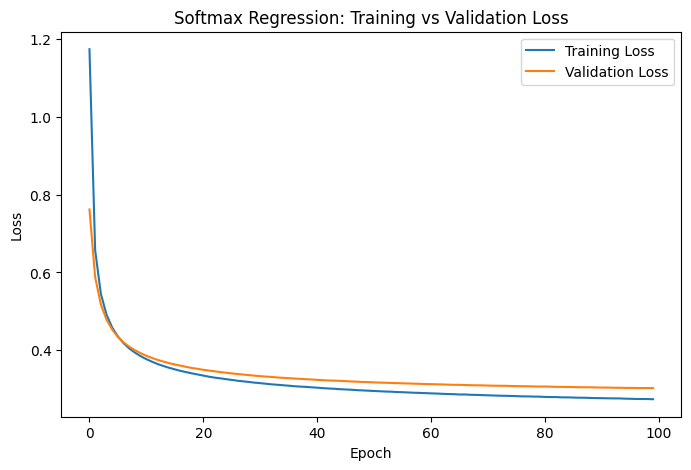

In [12]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Softmax Regression: Training vs Validation Loss')
plt.legend()
plt.show()

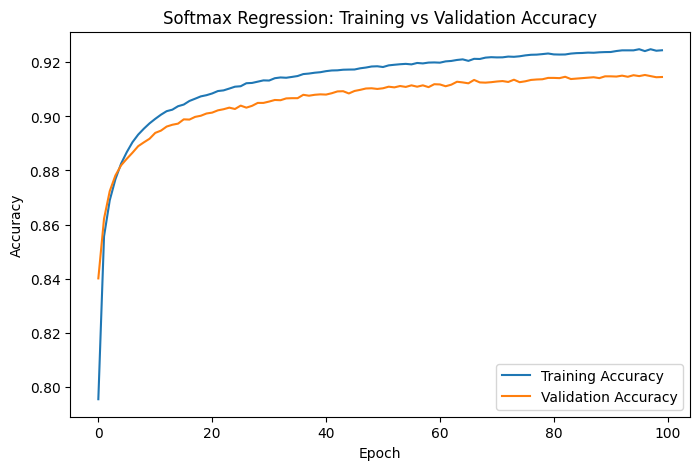

In [13]:
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Softmax Regression: Training vs Validation Accuracy')
plt.legend()
plt.show()


Final Test Accuracy: 0.9167


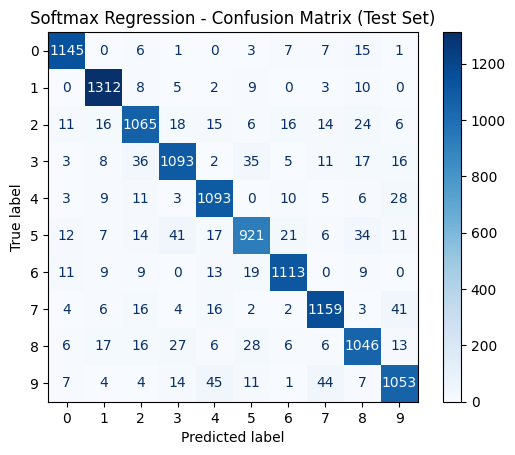

In [14]:
with torch.no_grad():
    logits_test = X_test @ W + b
    y_test_pred = softmax(logits_test)
    y_test_pred_label = y_test_pred.argmax(dim=1)

test_acc = (y_test_pred_label == y_test).float().mean().item()
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test, y_test_pred_label)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Softmax Regression - Confusion Matrix (Test Set)")
plt.show()

Accuracy for digit 0: 0.9662
Accuracy for digit 1: 0.9726
Accuracy for digit 2: 0.8942
Accuracy for digit 3: 0.8915
Accuracy for digit 4: 0.9358
Accuracy for digit 5: 0.8496
Accuracy for digit 6: 0.9408
Accuracy for digit 7: 0.9250
Accuracy for digit 8: 0.8933
Accuracy for digit 9: 0.8849


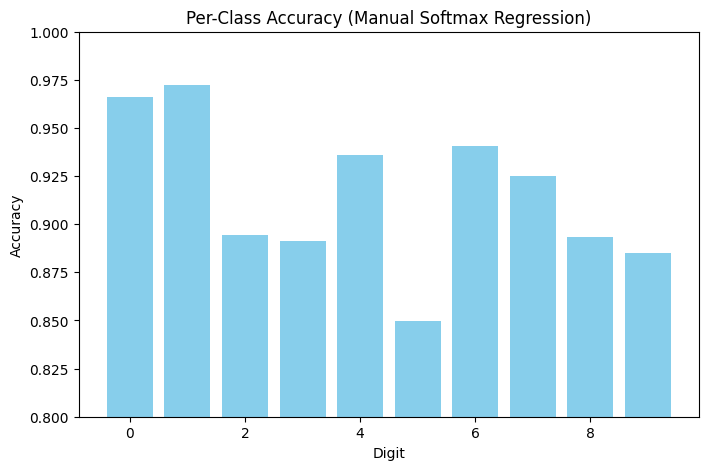

In [15]:
classes = list(range(10))
per_class_acc = []
for c in classes:
    mask = (y_test == c)
    acc_c = (y_test_pred_label[mask] == y_test[mask]).float().mean().item()
    per_class_acc.append(acc_c)
    print(f"Accuracy for digit {c}: {acc_c:.4f}")

plt.figure(figsize=(8,5))
plt.bar(classes, per_class_acc, color='skyblue')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy (Manual Softmax Regression)')
plt.ylim(0.8, 1.0)
plt.show()

In [16]:
model_torch = nn.Sequential(
    nn.Linear(784, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_torch.parameters(), lr=0.01)

In [17]:
epochs_builtin = 100
for epoch in range(epochs_builtin):
    total_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        outputs = model_torch(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    print(f"[PyTorch Model] Epoch {epoch+1}/{epochs_builtin} | "
          f"Loss: {total_loss/len(train_loader):.4f} | Train Acc: {correct/total:.4f}")

[PyTorch Model] Epoch 1/100 | Loss: 1.1756 | Train Acc: 0.7678
[PyTorch Model] Epoch 2/100 | Loss: 0.6592 | Train Acc: 0.8540
[PyTorch Model] Epoch 3/100 | Loss: 0.5466 | Train Acc: 0.8679
[PyTorch Model] Epoch 4/100 | Loss: 0.4924 | Train Acc: 0.8762
[PyTorch Model] Epoch 5/100 | Loss: 0.4590 | Train Acc: 0.8819
[PyTorch Model] Epoch 6/100 | Loss: 0.4360 | Train Acc: 0.8863
[PyTorch Model] Epoch 7/100 | Loss: 0.4188 | Train Acc: 0.8902
[PyTorch Model] Epoch 8/100 | Loss: 0.4054 | Train Acc: 0.8927
[PyTorch Model] Epoch 9/100 | Loss: 0.3947 | Train Acc: 0.8952
[PyTorch Model] Epoch 10/100 | Loss: 0.3854 | Train Acc: 0.8972
[PyTorch Model] Epoch 11/100 | Loss: 0.3777 | Train Acc: 0.8987
[PyTorch Model] Epoch 12/100 | Loss: 0.3712 | Train Acc: 0.9003
[PyTorch Model] Epoch 13/100 | Loss: 0.3652 | Train Acc: 0.9018
[PyTorch Model] Epoch 14/100 | Loss: 0.3601 | Train Acc: 0.9030
[PyTorch Model] Epoch 15/100 | Loss: 0.3558 | Train Acc: 0.9040
[PyTorch Model] Epoch 16/100 | Loss: 0.3513 | Tra

In [18]:
with torch.no_grad():
    outputs_test = model_torch(X_test)
    preds_test = outputs_test.argmax(dim=1)
    acc_torch_test = (preds_test == y_test).float().mean().item()

print(f"\nPyTorch Built-in Softmax Regression - Test Accuracy: {acc_torch_test:.4f}")


PyTorch Built-in Softmax Regression - Test Accuracy: 0.9163


Digit 0: 0.9654
Digit 1: 0.9726
Digit 2: 0.8950
Digit 3: 0.8931
Digit 4: 0.9298
Digit 5: 0.8441
Digit 6: 0.9417
Digit 7: 0.9202
Digit 8: 0.8950
Digit 9: 0.8933


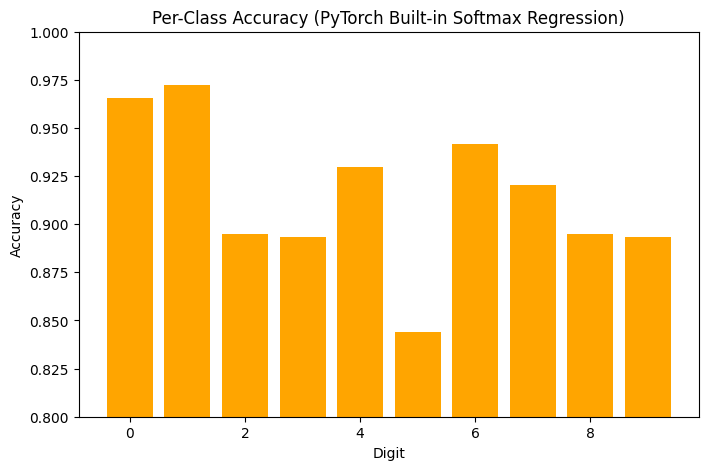

In [19]:
classes = list(range(10))
per_class_acc_torch = []

for c in classes:
    mask = (y_test == c)
    acc_c = (preds_test[mask] == y_test[mask]).float().mean().item()
    per_class_acc_torch.append(acc_c)
    print(f"Digit {c}: {acc_c:.4f}")

# Optional: visualize as bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(classes, per_class_acc_torch, color='orange')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy (PyTorch Built-in Softmax Regression)')
plt.ylim(0.8, 1.0)
plt.show()

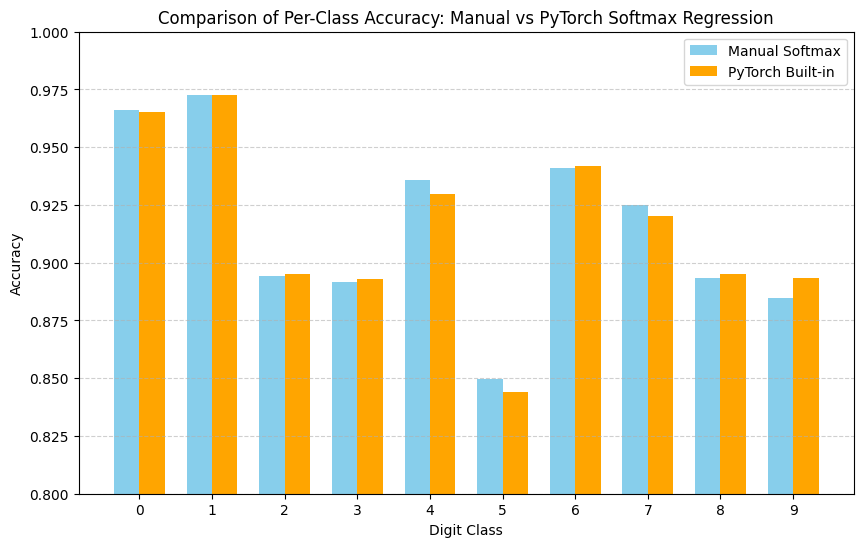

Digit | Manual Acc | PyTorch Acc | Difference
---------------------------------------------
   0   |   0.9662   |   0.9654   |   0.0008
   1   |   0.9726   |   0.9726   |   0.0000
   2   |   0.8942   |   0.8950   |   0.0008
   3   |   0.8915   |   0.8931   |   0.0016
   4   |   0.9358   |   0.9298   |   0.0060
   5   |   0.8496   |   0.8441   |   0.0055
   6   |   0.9408   |   0.9417   |   0.0008
   7   |   0.9250   |   0.9202   |   0.0048
   8   |   0.8933   |   0.8950   |   0.0017
   9   |   0.8849   |   0.8933   |   0.0084


In [20]:
manual_acc = np.array(per_class_acc)
torch_acc = np.array(per_class_acc_torch)

# --- Plot comparison ---
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(classes))

plt.bar(x - bar_width/2, manual_acc, width=bar_width, label='Manual Softmax', color='skyblue')
plt.bar(x + bar_width/2, torch_acc, width=bar_width, label='PyTorch Built-in', color='orange')

plt.xlabel('Digit Class')
plt.ylabel('Accuracy')
plt.title('Comparison of Per-Class Accuracy: Manual vs PyTorch Softmax Regression')
plt.xticks(x, classes)
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# --- Print numerical summary ---
print("Digit | Manual Acc | PyTorch Acc | Difference")
print("---------------------------------------------")
for c in range(10):
    diff = abs(manual_acc[c] - torch_acc[c])
    print(f"  {c:>2}   |   {manual_acc[c]:.4f}   |   {torch_acc[c]:.4f}   |   {diff:.4f}")